In [1]:
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import interp1d
from scipy.signal import hilbert,savgol_filter
import nrutils
from nrutils.core.nrsc import *
from nrutils import scsearch,gwylm, simdir2scentry
from nrutils.core import basics
from sympy import *
import lmfit
import json
from mpl_toolkits.mplot3d import *
from random import random, seed
from matplotlib import cm
from positive import leaver
import d

(positive)>> Applying custom matplotlib settings.


In [2]:
matplotlib.style.use('classic')

In [24]:
with open("test.json","r") as f:
    new_dic = json.load(f)

In [25]:
def derivative(ylm_dic):
    alpha_der = np.diff(savgol_filter(np.array(ylm_dic['alpha']),21,2))/np.diff(np.array(ylm_dic['frequency']))
    sym_phase_der = np.array(ylm_dic['sym phase der'])
    asym_phase_der = np.array(ylm_dic['asym phase der'])
    
    return sym_phase_der, alpha_der, asym_phase_der

In [28]:
rest = {}
phase_der_recon = {}

def transition(x,S,angle,a,A0,B0,tp):
    return 0.5*(1-3/(2*a)*((x-tp)-(x-tp)**3/3/a**2))*(0.5*S - angle + A0)+ \
    0.5*(1+3/(2*a)*((x-tp)-(x-tp)**3/3/a**2))*(S + B0)

#def model_phase(phase_dic):
for j in new_dic.keys():
    frequency = new_dic[j][1]['frequency'][1:]
    sample_sym_phase_der, sample_alpha_der, sample_asym_phase_der = derivative(new_dic[j][1])
    S_interp = scipy.interpolate.interp1d(new_dic[j][1]['frequency'][1:],sample_sym_phase_der-new_dic[j][1]['shift'],fill_value="extrapolate")
    A_interp = scipy.interpolate.interp1d(new_dic[j][1]['frequency'][1:],sample_asym_phase_der-new_dic[j][1]['shift'],fill_value="extrapolate")
    angle_interp = scipy.interpolate.interp1d(new_dic[j][1]['frequency'][1:],sample_alpha_der,fill_value="extrapolate")
    transition_pt = 0.85 * new_dic[j][1]['rd']
    
    
    model = lmfit.Model(transition,independent_vars=['x','S','angle'])

    model.set_param_hint('a', value=0.005,vary=False)
    model.set_param_hint('A0', value=40, vary= False)
    model.set_param_hint('B0', value=-35, vary = True)
#     model.set_param_hint('B', value=1)
#     model.set_param_hint('B1', value=1)
    model.set_param_hint('tp', value=transition_pt,vary = False)
    par = model.make_params()
    
    xnew = np.linspace(transition_pt - 0.008,transition_pt + 0.008,1000)
    S = S_interp(xnew)
    angle = angle_interp(xnew)
#     xnew = np.linspace(0.06,0.082,1000)
    
    result = model.fit(data = A_interp(xnew), x=xnew,S = S,angle = angle, params=par, method='least_squares', nan_policy='omit')

    rest[j] = result#model_phase(new_dic[j])
    a = rest[j].params['a'].value
    A0 = rest[j].params['A0'].value
    B0 = rest[j].params['B0'].value
#     B = rest[j].params['B'].value
#     B1 = rest[j].params['B1'].value
    
    freq1 = np.linspace(0.01,transition_pt-a,1000)
    freq2 = np.linspace(transition_pt - a, transition_pt + a,1000)
    freq3 = np.linspace(transition_pt + a,0.14,1000)
    frequency = list(freq1)+list(freq2)+list(freq3)  
    phase_der_recon[j] = [frequency, list(0.5*S_interp(freq1) - angle_interp(freq1)+ A0) \
                         +list(transition(freq2,S_interp(freq2),angle_interp(freq2),a,A0,B0,transition_pt)) + list(S_interp(freq3) + B0)]
    #phase_der_recon[j] = [frequency, list(0.5*S_interp(freq1) - angle_interp(freq1)+ 40) \
     #                     +list(transition(freq2,S_interp(freq2),angle_interp(freq2),a,40,-35,transition_pt)) + list(S_interp(freq3) - 35)]
    

In [6]:
a_list = {}
A0_list = {}
B0_list = {}
# B_list = {}
# B1_list = {}
for i in rest.keys():
    a_list[i] = rest[i].params['a'].value 
    A0_list[i] = rest[i].params['A0'].value
    B0_list[i] = rest[i].params['B0'].value 
#     B_list[i] = rest[i].params['B'].value 
#     B1_list[i] = rest[i].params['B1'].value 

In [7]:
a_full1 = [a_list[str(j)] for j in [6,7,8,9,10,26,27,28,29,30,46,47,48,49,50,66,67,68,69,70]]
A0_full1 = [A0_list[str(j)] for j in [6,7,8,9,10,26,27,28,29,30,46,47,48,49,50,66,67,68,69,70]]
B0_full1 = [B0_list[str(j)] for j in [6,7,8,9,10,26,27,28,29,30,46,47,48,49,50,66,67,68,69,70]]

a_full2 = [a_list[str(j)] for j in [16,17,18,19,20,36,37,38,39,40,56,57,58,59,60,76,77,78,79,80]]
A0_full2 = [A0_list[str(j)] for j in [16,17,18,19,20,36,37,38,39,40,56,57,58,59,60,76,77,78,79,80]]
B0_full2 = [B0_list[str(j)] for j in [16,17,18,19,20,36,37,38,39,40,56,57,58,59,60,76,77,78,79,80]]

In [8]:
z1full = np.array(a_full1).reshape(4,5)
z2full = np.array(A0_full1).reshape(4,5)
z3full = np.array(B0_full1).reshape(4,5)

z1hfull = np.array(a_full2).reshape(4,5)
z2hfull = np.array(A0_full2).reshape(4,5)
z3hfull = np.array(B0_full2).reshape(4,5)

(-10, 500)

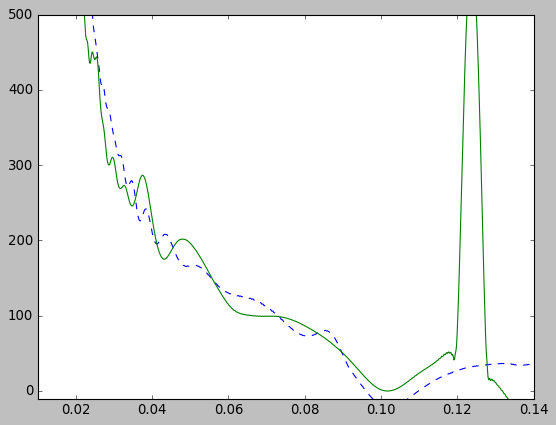

In [9]:
plt.plot(phase_der_recon['76'][0],phase_der_recon['76'][1],'--')
plt.plot(new_dic['76'][1]['frequency'][1:],np.array(new_dic['76'][1]['asym phase der'])-new_dic['76'][1]['shift'])
plt.xlim(0.01,0.14)
plt.ylim(-10,500)

## Phase reconstruction from fit of asymmetry phase derivate

In [29]:
data_phase ={}
data_recon = {}
data_recon2 = {}
for key in new_dic.keys():
    yy = scipy.integrate.cumtrapz(phase_der_recon[key][1],phase_der_recon[key][0])
    zz = scipy.integrate.cumtrapz(new_dic[key][1]['asym phase der'],new_dic[key][1]['frequency'][1:])
    xx = scipy.integrate.cumtrapz(new_dic[key][1]['sym phase der'],new_dic[key][1]['frequency'][1:])
    data_phase[key] = scipy.interpolate.interp1d(np.array(new_dic[key][1]['frequency'][2:]),zz)
    data_recon[key] = scipy.interpolate.interp1d(np.array(phase_der_recon[key][0][1:]),new_dic[key][1]['shift']*np.array(phase_der_recon[key][0][1:])-13843+143)
    data_recon2[key] = scipy.interpolate.interp1d(np.array(phase_der_recon2[key][0][1:]),new_dic[key][1]['shift']*np.array(phase_der_recon2[key][0][1:])-13843+143)

In [33]:
new_fre = np.linspace(0.02,0.14,1000)

In [36]:
key='57'

In [92]:
plt.figure(figsize=(14,6))
plt.subplot(1,3,1)
plt.plot(new_fre,data_phase['16'](new_fre)-data_recon['16'](new_fre)-12/0.1*new_fre,label='2 parameter')
# plt.plot(new_fre,data_phase['16'](new_fre)-data_recon2['16'](new_fre),label = '1 parameter')
# plt.legend(loc='lower right')

plt.subplot(1,3,2)
plt.plot(new_fre,data_phase['19'](new_fre)-data_recon['19'](new_fre)-10/0.12*new_fre,label='2 parameter')
# plt.plot(new_fre,data_phase['19'](new_fre)-data_recon2['19'](new_fre),label = '1 parameter')
# plt.legend(loc='lower right')

plt.subplot(1,3,3)
plt.plot(new_fre,data_phase['20'](new_fre)-data_recon['20'](new_fre)-,label='2 parameter')
# plt.plot(new_fre,data_phase['20'](new_fre)-data_recon2['20'](new_fre),label = '1 parameter')
# plt.legend(loc='lower right')
plt.suptitle(r'q1:$\Delta\Phi_{asym}$ - data & recon',fontsize=16)

SyntaxError: invalid syntax (<ipython-input-92-857575bf0c5a>, line 13)

Text(0.5,0.98,'q2: $\\Delta\\Phi_{asym}$ - data & recon')

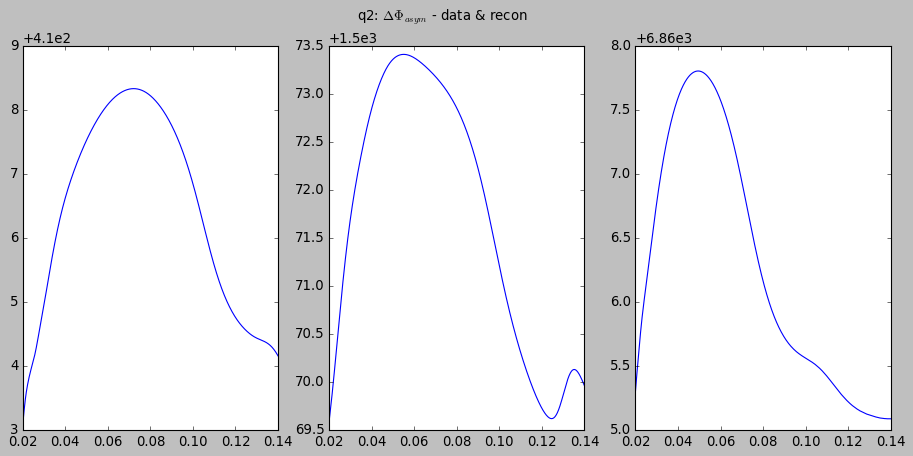

In [81]:
plt.figure(figsize=(14,6))
plt.subplot(1,3,1)
plt.plot(new_fre,data_phase['36'](new_fre)-data_recon['36'](new_fre)-16/0.12*new_fre,label='2 parameter')
# plt.plot(new_fre,data_phase['36'](new_fre)-data_recon2['36'](new_fre),label = '1 parameter')
# plt.legend(loc='lower right')

plt.subplot(1,3,2)
plt.plot(new_fre,data_phase['37'](new_fre)-data_recon['37'](new_fre)-13/0.12*new_fre,label='2 parameter')
# plt.plot(new_fre,data_phase['37'](new_fre)-data_recon2['37'](new_fre),label = '1 parameter')
# plt.legend(loc='lower right')

plt.subplot(1,3,3)
plt.plot(new_fre,data_phase['40'](new_fre)-data_recon['40'](new_fre)-10/0.12*new_fre,label='2 parameter')
# plt.plot(new_fre,data_phase['40'](new_fre)-data_recon2['40'](new_fre),label = '1 parameter')
# plt.legend(loc='lower right')
plt.suptitle(r'q2: $\Delta\Phi_{asym}$ - data & recon')

Text(0.5,0.98,'q4: $\\Delta\\Phi_{asym}$ - data & recon')

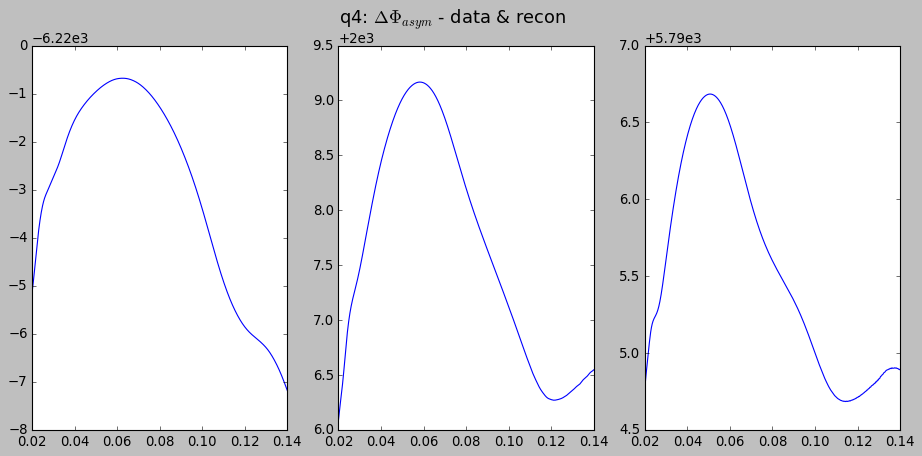

In [88]:
plt.figure(figsize=(14,6))
plt.subplot(1,3,1)
plt.plot(new_fre,data_phase['56'](new_fre)-data_recon['56'](new_fre)-19/0.12*new_fre,label='2 parameter')
# plt.plot(new_fre,data_phase['56'](new_fre)-data_recon2['56'](new_fre),label = '1 parameter')
# plt.legend(loc='lower right')

plt.subplot(1,3,2)
plt.plot(new_fre,data_phase['59'](new_fre)-data_recon['59'](new_fre)-8/0.12*new_fre,label='2 parameter')
# plt.plot(new_fre,data_phase['59'](new_fre)-data_recon2['59'](new_fre),label = '1 parameter')
# plt.legend(loc='lower right')

plt.subplot(1,3,3)
plt.plot(new_fre,data_phase['60'](new_fre)-data_recon['60'](new_fre)-6.5/0.12*new_fre,label='2 parameter')
# plt.plot(new_fre,data_phase['60'](new_fre)-data_recon2['60'](new_fre),label = '1 parameter')
# plt.legend(loc='lower right')
plt.suptitle(r'q4: $\Delta\Phi_{asym}$ - data & recon', fontsize = 16)

Text(0.5,0.98,'q8:$\\Delta\\Phi_{asym}$ - data & recon')

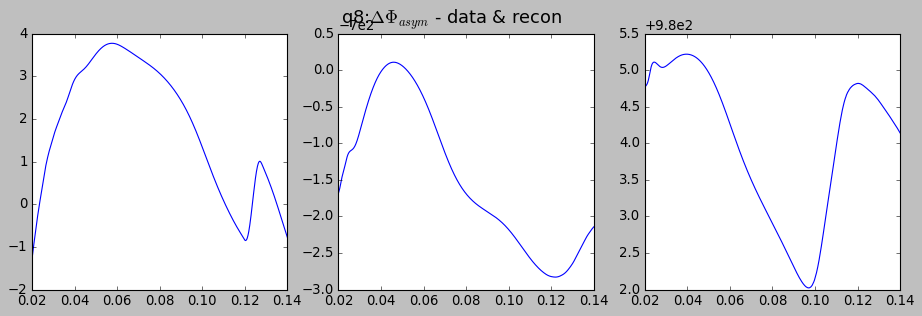

In [78]:
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.plot(new_fre,data_phase['76'](new_fre)-data_recon['76'](new_fre)-16/0.12*new_fre,label='2 parameter')
# plt.plot(new_fre,data_phase['76'](new_fre)-data_recon2['76'](new_fre),label = '1 parameter')
# plt.legend(loc='lower right')

plt.subplot(1,3,2)
plt.plot(new_fre,data_phase['79'](new_fre)-data_recon['79'](new_fre)-8/0.1*new_fre,label='2 parameter')
# plt.plot(new_fre,data_phase['79'](new_fre)-data_recon2['79'](new_fre),label = '1 parameter')
# plt.legend(loc='lower right')

plt.subplot(1,3,3)
plt.plot(new_fre,data_phase['80'](new_fre)-data_recon['80'](new_fre)-10/0.12*new_fre,label='2 parameter')
# plt.plot(new_fre,data_phase['80'](new_fre)-data_recon2['80'](new_fre),label = '1 parameter')
# plt.legend(loc='lower right')
plt.suptitle(r'q8:$\Delta\Phi_{asym}$ - data & recon',fontsize=16)

In [ ]:
new_dic[key][0]

In [ ]:
from positive import calc_chi_p,calc_chi_eff

In [ ]:
Y = simdir2scentry('/Users/shrobanaghosh/mnt/NR_data/simulations/q8/q8a08t30dPm9.35_r0.5_T_96_360')

In [ ]:
y = gwylm(Y[0],lmax = 2,load_dynamics= False,clean=True, verbose = False,dt=0.5,pad = 2000)

In [ ]:
y_j = y.__calc_j_of_t_frame__()

In [ ]:
y_co = y_j.__calc_coprecessing_frame__(transform_domain='td',kind = 'psi4',verbose=False,safe_domain_range = [0,0.15])

In [ ]:
# plt.plot(phase_der_recon[key][0][1:],amp_func)
plt.plot(new_dic[key][1]['frequency'],new_dic[key][1]['FD asym'])
plt.plot(y.f[1:],0.5*np.real(y_co[2,2]['strain'].fd_y[1:]-np.conj(np.flip(y_co[2,-2]['strain'].fd_y))[:-1]))
plt.xlim(0.075,0.08)

## Amplitude

In [ ]:
amp = np.abs(np.array(new_dic[key][1]['FD asym'])+1j*np.array(new_dic[key][1]['FD asym imag']))
amp_interp = scipy.interpolate.interp1d(np.array(new_dic[key][1]['frequency']),amp,fill_value = 'extrapolate')
amp_func = amp_interp(phase_der_recon[key][0][1:])

In [ ]:
plt.plot(new_dic[key][1]['frequency'],amp)
plt.plot(phase_der_recon[key][0][1:],amp_func)
plt.xlim(0.01,0.14)

In [ ]:
# plt.plot(phase_der_recon[key][0][1:],amp_func)
plt.plot(new_dic[key][1]['frequency'],new_dic[key][1]['FD asym'])
plt.plot(y.f[1:],0.5*np.real(y_co[2,2]['strain'].fd_y[1:]-np.conj(np.flip(y_co[2,-2]['strain'].fd_y))[:-1]))
plt.xlim(0.075,0.08)

In [ ]:
# plt.plot(phase_der_recon[key][0][1:],amp_func*np.exp(1j*(1.5+np.array(yy)+(400+new_dic[key][1]['shift'])*np.array(phase_der_recon[key][0][1:])-13843+120)), label = "NR amp * phase recon integrated")
plt.plot(np.array(new_dic[key][1]['frequency'])[2:],amp[2:]*np.exp(1j*zz), label = "NR amp * NR phase der integrated") 
plt.plot(np.array(new_dic[key][1]['frequency']),np.array(new_dic[key][1]['FD asym']),label = "NR asym - real") 
plt.xlim(0.05,0.058)
plt.legend(fontsize = 10)

## symmetric phase from PNR

In [11]:
eta = 0.16#0.098765
m1 = 4/5.
m2 = 1/5.
theta = 60*np.pi/180
chi2 = 0.0*np.cos(theta)
chi1 = 0.8*np.cos(theta)
chi = (m1*chi1 + m2*chi2)/(m1+m2)
chip = 0.0*np.sin(theta)+0.8*np.sin(theta)

In [12]:
u = cos(theta)
u2 = u*u
u3 = u2*u
u4 = u3*u
eta2 = eta*eta
eta3 = eta2*eta
delta = sqrt(1-4*eta)
delta2 = delta*delta
delta3 = delta2*delta
a1=chi2

nu4 = 5.66142852e+00*(eta) + -1.75185191e+00*(u) + 3.86433717e+00*(a1) + 1.92242858e+00*(delta) + \
-1.34786548e+00 + 9.33324812e-01*(u*delta) + 2.44811381e+00*(u*a1) + -2.49149423e-01*(u*u) + \
6.74874271e+00*(u*eta) + -4.71136352e+00*(delta*a1) + -1.55301900e+01*(eta*a1) + -7.70273163e+00*(eta*delta) + \
-9.31220572e+00*(u*eta*a1) + -1.04028798e-01*(u2*a1) + 1.35024694e+00*(u2*eta) + 1.78833954e+01*(eta*delta*a1) + \
-1.13187176e+00*(u*delta*a1) + 8.93354618e-01*(u2*eta*delta) + 2.61688280e-01*(u2*delta*a1) + 3.25933979e-01*(u3*eta) \
+ 9.81938835e-01*(u3*delta) + -3.25617848e+00*(u3*a1) + -6.16129827e+00*(u3*eta*delta) + 1.23939224e+01*(u3*eta*a1) + \
1.98263178e+00*(u3*delta*a1) + -3.08504750e+00*(u2*eta*delta*a1)

nu5 = -4.44449010e-02*(u) + 2.51634780e-03 + -1.36091908e-02*(eta) + -2.90135018e-02*(a1) + \
4.23237059e-02*(u*delta) + 4.39593625e-04*(u*a1) + 1.31130708e-01*(eta*a1) + 1.75422869e-01*(u*eta) + \
6.76214593e-02*(delta*a1) + 1.24411352e-01*(u*u) + -1.17980678e-01*(u*eta*delta) + -1.53346102e-01*(u2*delta) + \
-1.63723914e-01*(eta*delta*a1) + -2.72154015e-01*(u2*a1) + 1.78196395e-02*(u*delta*a1) + -4.95267547e-01*(u2*eta) + \
1.07509291e+00*(u2*eta*a1) + 4.81418914e-01*(u2*eta*delta) + 3.10640613e-01*(u2*delta*a1) + \
-9.82741533e-01*(u2*eta*delta*a1)

nu6 = 2.85656511e-02*(a1) + -1.70920584e-01*(eta) + 5.12290142e-02*(u) + 9.99751580e-03 + -1.80315397e-01*(u*a1) +\
1.69846446e-01*(u*u) + -1.13709325e+00*(u*eta) + 8.58716297e-01*(eta*eta) + 7.47553504e+00*(u*eta*eta) + \
3.26831091e+00*(u*eta*a1) + -1.31548357e+00*(eta2*eta) + -1.26424461e+00*(eta2*a1) + -4.10119409e-01*(u2*a1) + \
-1.94427721e+00*(u2*eta) + -4.91922013e-02*(u2*u) + -1.89678978e+01*(u*eta2*a1) + -1.50558179e+01*(u*eta2*eta) + \
4.49899711e+00*(u2*eta*a1) + 5.89518853e+00*(u2*eta*eta) + 3.26221102e+00*(eta3*a1) + -1.31307301e-01*(u3*u) + \
8.67415199e-01*(u3*eta) + 2.84356226e-01*(u3*a1) + -4.87907406e+00*(u3*eta*a1) + -5.03732334e+00*(u3*eta*eta) + \
-3.37450600e+00*(u2*eta2*eta) + 3.53422842e+01*(u*eta3*a1) + 1.09492960e+00*(u4*eta) + 3.79842273e-01*(u4*a1) + \
-1.37426062e+01*(u2*eta2*a1) + 9.38444796e+00*(u3*eta2*eta) + -4.02211094e+00*(u4*eta*a1) + \
2.76469344e+01*(u3*eta2*a1) + 9.47779299e+00*(u2*eta3*a1) + -5.08554538e+01*(u3*eta3*a1) + \
-9.16402926e+00*(u4*eta2*eta) + 9.95849620e+00*(u4*eta2*a1)

In [13]:
pwca.core.pwca_dphi_helper

NameError: name 'pwca' is not defined

In [14]:
xi = -1 + chi
xi2 = xi*xi
xi3 = xi2*xi
eta2 = eta*eta
freq=np.array(new_dic['57'][1]['frequency'])
f = freq[(freq>0.01)&(freq<0.14)]

alpha1 =  43.31514709695348 + 638.6332679188081*eta \
    + (-32.85768747216059 + 2415.8938269370315*eta - 5766.875169379177*eta2)*xi \
    + (-61.85459307173841 + 2953.967762459948*eta - 8986.29057591497*eta2)*xi2 \
    + (-21.571435779762044 + 981.2158224673428*eta - 3239.5664895930286*eta2)*xi3


alpha2 =  -0.07020209449091723 - 0.16269798450687084*eta \
    + (-0.1872514685185499 + 1.138313650449945*eta - 2.8334196304430046*eta2)*xi \
    + (-0.17137955686840617 + 1.7197549338119527*eta - 4.539717148261272*eta2)*xi2 \
    + (-0.049983437357548705 + 0.6062072055948309*eta - 1.682769616644546*eta2)*xi3


alpha3 = 9.5988072383479 - 397.05438595557433*eta \
    + (16.202126189517813 - 1574.8286986717037*eta + 3600.3410843831093*eta2)*xi \
    + (27.092429659075467 - 1786.482357315139*eta + 5152.919378666511*eta2)*xi2 \
    + (11.175710130033895 - 577.7999423177481*eta + 1808.730762932043*eta2)*xi3

alpha4 = -0.02989487384493607 + 1.4022106448583738*eta \
    + (-0.07356049468633846 + 0.8337006542278661*eta + 0.2240008282397391*eta2)*xi \
    + (-0.055202870001177226 + 0.5667186343606578*eta + 0.7186931973380503*eta2)*xi2 \
    + (-0.015507437354325743 + 0.15750322779277187*eta + 0.21076815715176228*eta2)*xi3


alpha5 = 0.9974408278363099 - 0.007884449714907203*eta \
    + (-0.059046901195591035 + 1.3958712396764088*eta - 4.516631601676276*eta2)*xi \
    + (-0.05585343136869692 + 1.7516580039343603*eta - 5.990208965347804*eta2)*xi2 \
    + (-0.017945336522161195 + 0.5965097794825992*eta - 2.0608879367971804*eta2)*xi3

final_spin = d.FinalSpin0815_s(eta,chi)
fring = d.fring(eta,chi1,chi2,final_spin)
fdamp = d.fdamp(eta,chi1,chi2,final_spin)

new_alpha4 = alpha4 + ( chip * nu4 )
new_fring = fring + chip*nu5
new_fdamp = fdamp + chip*nu6
new_dfring = f - alpha5*new_fring

part1 = alpha1 + alpha2*f**(-2.0) + alpha3*f**(-0.25)
part2 = new_alpha4 / (  new_fdamp*(1 + (new_dfring**2)/(new_fdamp**2))  )

template_dphi = part1 + part2
template_dphi *= -1.0/eta
template_dphi = template_dphi-min(template_dphi[(f>0.03)*f<(0.12)])

#return template_dphi-min(template_dphi[(f>0.03)*f<(0.12)]) if isinstance(f,ndarray) else template_dphi

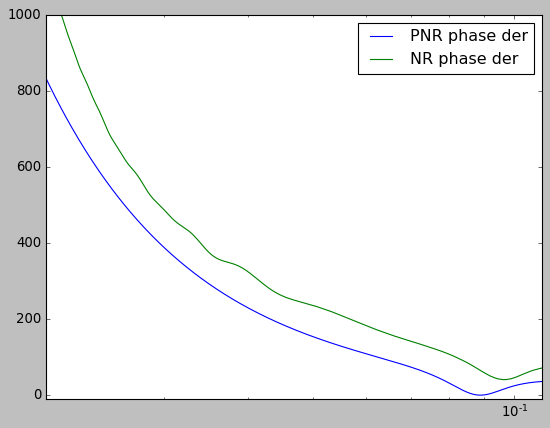

In [15]:
plt.plot(f,template_dphi,label = 'PNR phase der')
plt.plot(np.array(new_dic['57'][1]['frequency'][1:]),np.array(new_dic['57'][1]['sym phase der'])-new_dic['57'][1]['shift'],label = 'NR phase der')
plt.xlim(0.02,0.11)
plt.xscale('log')
plt.ylim(-10,1000)
plt.legend()

In [16]:
template_dphi_int = scipy.integrate.cumtrapz(template_dphi,f)

In [17]:
plt.plot(f[1:],template_dphi_int+(new_dic[key][1]['shift'])*f[1:]-11620,label = 'PNR phase')
plt.plot(new_dic[key][1]['frequency'],np.unwrap(np.angle(np.array(new_dic[key][1]['FD sym']) \
                                                             +1j*np.array(new_dic[key][1]['FD sym imag']))),label='NR phase')
plt.xlim(0,0.14)
plt.ylim(-14500,-10500)
plt.axvline(0.0097,c='k')
plt.legend()

NameError: name 'key' is not defined

In [ ]:
np.unwrap(np.angle(np.array(new_dic[key][1]['FD sym']) +1j*np.array(new_dic[key][1]['FD sym imag'])))[np.array(new_dic[key][1]['frequency'])>=0.0097]